### **BPIC 2012 - A_PREACCEPTED**


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from data.processor import *
from data.args import *

from tensorflow.keras.utils import to_categorical

### Define the experiment parameters

In [3]:
milestone = 'A_PREACCEPTED' #'A_PREACCEPTED' # 'W_Nabellen offertes','W_Valideren aanvraag', 'All'
experiment =  'OHE' #'Standard'#'OHE', 'No_loops'
n_size = 5

### Setting up the key parameters


In [4]:
# For local environment only
MY_WORKSPACE_DIR = os.path.join(os.getcwd(),'BPIC12')
MILESTONE_DIR = os.path.join(os.path.join(MY_WORKSPACE_DIR, milestone),experiment)

In [5]:
args = get_parameters('bpic12', MILESTONE_DIR, MY_WORKSPACE_DIR, milestone, experiment,n_size)

### Data Preprocessing

In [6]:
if milestone == 'All':
  log_df = pd.read_csv(args['file_name_all'])
  log_df = log_df.reset_index(drop=True)
else:
  log_df = pd.read_csv(args['file_name'])
  log_df = log_df.reset_index(drop=True)

log_df.head()

prefix_id  caseid               task      role                end_timestamp  \
0  173898_3  173898        A_SUBMITTED  role_112  2011-10-03 00:05:39.8170000   
1  173898_2  173898        A_SUBMITTED  role_112  2011-10-03 00:05:39.8170000   
2  173898_4  173898        A_SUBMITTED  role_112  2011-10-03 00:05:39.8170000   
3  173898_3  173898  A_PARTLYSUBMITTED  role_112  2011-10-03 00:05:40.0090000   
4  173898_2  173898  A_PARTLYSUBMITTED  role_112  2011-10-03 00:05:40.0090000   

                   trace_start  timelapsed                next_activity  \
0  2011-10-03 00:05:39.8170000           0  W_Calling after sent offers   
1  2011-10-03 00:05:39.8170000           0                   A_ACCEPTED   
2  2011-10-03 00:05:39.8170000           0                  O_CANCELLED   
3  2011-10-03 00:05:39.8170000           0  W_Calling after sent offers   
4  2011-10-03 00:05:39.8170000           0                   A_ACCEPTED   

                                      milestone  milestone_id  task_index  \
0  W_Filling in information for the application             3           1   
1  W_Filling in information for the application             2           1   
2                   W_Calling after sent offers             4           1   
3  W_Filling in information for the application             3           2   
4  W_Filling in information for the application             2           2   

   timelapsed_2  
0             0  
1             0  
2             0  
3             0  
4             0

Milestone Extraction

We expect to filter the prefixes by the milestone, and train the model for each milestone separately to observe if there will be an improvement in the model explainability as well as performance


In [7]:
if milestone != 'All':
  log_df = log_df[log_df['milestone'] == milestone]

In [8]:
def balance(df):
  # Dictonary with the mapping of columns
  
  #based on the paper : BPIC_2012 Winner, DOI: 10.1007/978-3-642-36285-9_24

  group_dict = {'A_ACCEPTED':'A_ACCEPTED',    
    'A_ACTIVATED' :   'A_APPROVED_ACTIVATED',
    'A_APPROVED':  'A_APPROVED_ACTIVATED',
    'A_CANCELLED': 'A_CANCELLED_DECLINED' ,
    'A_DECLINED': 'A_CANCELLED_DECLINED' ,
    'A_PARTLYSUBMITTED': 'REDUNDANT',
    'A_PREACCEPTED':'A_PREACCEPTED',
    'A_REGISTERED' : 'REDUNDANT',
    'O_ACCEPTED' : 'REDUNDANT',
    'O_CANCELLED' :  'REDUNDANT' ,
    'O_CREATED':'REDUNDANT',
    'O_DECLINED' :'REDUNDANT' ,
    'O_SELECTED' : 'REDUNDANT', 
    'O_SENT':'O_SENT',
    'O_SENT_BACK' : 'O_SENT_BACK',
    'W_Filling in information for the application' :  'W_Filling in information for the application',
    'W_Fixing incoming lead': 'W_Fixing incoming lead',
    'W_Nabellen incomplete dossiers':'W_Nabellen incomplete dossiers',
    'W_Nabellen offertes':'W_Nabellen offertes',
    'W_Valideren aanvraag' : 'W_Valideren aanvraag'}


  df['next_activity'].replace(group_dict, inplace=True)
  #Dropping the minority classes
  df = df.drop(df[df.next_activity == 'REDUNDANT'].index)
 

  return df

Balancing the dataset


In [9]:
log_df = balance(log_df)

#replacing empty cells of categorical columns with 'none'
log_df = log_df.fillna('none')

#### Data Encoding and Vectorization

Index creating for data encoding
Function : `create_index(log_df, column)`, Author: Manuel Camargo, Edited by: Bemali Wickramanayake

In [10]:
# Index creation for activity
ac_index = create_index(log_df, 'task')
index_ac = {v: k for k, v in ac_index.items()}

# Index creation for unit
rl_index = create_index(log_df, 'role')
index_rl = {v: k for k, v in rl_index.items()}

# Index creation for next activity
ne_index = create_index(log_df, 'next_activity')
index_ne = {v: k for k, v in ne_index.items()}

#mapping the dictionary values as columns in the dataframe
log_df['ac_index'] = log_df['task'].map(ac_index)
log_df['rl_index'] = log_df['role'].map(rl_index)
log_df['ne_index'] = log_df['next_activity'].map(ne_index)

log_df.head()

prefix_id  caseid               task        role  \
44  174689_1  174689        A_SUBMITTED    role_112   
45  174689_1  174689  A_PARTLYSUBMITTED    role_112   
46  174689_1  174689      A_PREACCEPTED  role_10859   
47  174695_1  174695        A_SUBMITTED    role_112   
50  174695_1  174695  A_PARTLYSUBMITTED    role_112   

                  end_timestamp                  trace_start  timelapsed  \
44  2011-10-05 20:51:55.4310000  2011-10-05 20:51:55.4310000           0   
45  2011-10-05 20:51:55.6300000  2011-10-05 20:51:55.4310000           0   
46  2011-10-05 21:01:27.0720000  2011-10-05 20:51:55.4310000           1   
47  2011-10-05 20:55:35.2330000  2011-10-05 20:55:35.2330000           0   
50  2011-10-05 20:55:35.3500000  2011-10-05 20:55:35.2330000           0   

                                   next_activity      milestone  milestone_id  \
44                        W_Fixing incoming lead  A_PREACCEPTED             1   
45                        W_Fixing incoming lead  A_PREACCEPTED             1   
46                        W_Fixing incoming lead  A_PREACCEPTED             1   
47  W_Filling in information for the application  A_PREACCEPTED             1   
50  W_Filling in information for the application  A_PREACCEPTED             1   

    task_index  timelapsed_2  ac_index  rl_index  ne_index  
44           1             0         3        46         3  
45           2             0         1        46         3  
46           3             1         2         9         3  
47           1             0         3        46         2  
50           2             0         1        46         2

Splitting the dataframe into test and train sets

Function : `split_train_test(df, percentage)`, Author: Bemali Wickramanayake

In [11]:
# Split validation datasets
log_df_train, log_df_test = split_train_test(log_df, 0.3) # 70%/30%

Normalize Numerical Features

Function : `normalize_events(log_df,args,numerical_features)`, Author: Manuel Camargo, Edited by: Bemali Wickramanayake


In [12]:
numerical_features = ['timelapsed']
log_df_train = normalize_events(log_df_train,args,numerical_features)
log_df_test = normalize_events(log_df_test,args,numerical_features)

In [13]:
training_traces = len(log_df_train['prefix_id'].unique())
test_traces = len(log_df_test['prefix_id'].unique())

print('Number of traces in training set is:'+str(training_traces))
print('Number of traces in test set is:'+str(test_traces))

Number of traces in training set is:5157
Number of traces in test set is:2210


Reformat events: converting the dataframe into a dictionary to aid vectorization

Function : `reformat_events(log_df, ac_index, rl_index,ne_index)`, Author: Renuka Sindagatta/ Manuel Camargo, Edited by: Bemali Wickramanayake




In [14]:
log_train = reformat_events(log_df_train, ac_index, rl_index,ne_index)
log_test = reformat_events(log_df_test, ac_index, rl_index,ne_index)

Vectorization: Convert the data dictionaries into trainable multi dimensional tensors

Function: `vectorization(log,ac_index, rl_index, ne_index,trc_len,cases)` , Author: Bemali Wickramanayake, Inspired by the code of: Renuka Sindagatta





In [15]:
#Obtain the maximum trc_len and cases for each set
trc_len_train, cases_train = lengths(log_train)
trc_len_test, cases_test = lengths(log_test)

trc_len = max([trc_len_train, trc_len_test])
print("trace_length: "+str(trc_len)+", training cases: "+str(cases_train)+", test cases: "+str(cases_test) )

trace_length: 15, training cases: 5158, test cases: 2211


converting the training log (dictionary) into a Tensor

In [16]:
vec_train = vectorization(log_train,ac_index, rl_index, ne_index,trc_len,cases_train)
vec_test = vectorization(log_test,ac_index, rl_index, ne_index,trc_len,cases_test)

#### Generating Initial Embedding Weights for Shared Model

In [17]:
ac_weights = to_categorical(sorted(index_ac.keys()), num_classes = len(ac_index))
ac_weights[0] = 0 # embedding weights for label none = 0

rl_weights =  to_categorical(sorted(index_rl.keys()), num_classes = len(rl_index))
rl_weights[0] = 0 # embeddig weights for label none = 0

#### Saving the Processed Tensor and Other Support Data

In [18]:
# saving the processed tensor
dirname = os.path.dirname(args['processed_training_vec'])

if not os.path.exists(dirname):
    os.makedirs(dirname)

with open(args['processed_training_vec'], 'wb') as fp:
    pickle.dump(vec_train, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open(args['processed_test_vec'], 'wb') as fp:
    pickle.dump(vec_test, fp, protocol=pickle.HIGHEST_PROTOCOL)


# converting the weights into a dictionary and saving
weights = {'ac_weights':ac_weights, 'rl_weights':rl_weights, 'next_activity':len(ne_index)}
with open(args['weights'], 'wb') as fp:
    pickle.dump(weights, fp, protocol=pickle.HIGHEST_PROTOCOL)

# converting the weights into a dictionary and saving
indexes = {'index_ac':index_ac, 'index_rl':index_rl,'index_ne':index_ne}
with open(args['indexes'], 'wb') as fp:
    pickle.dump(indexes, fp, protocol=pickle.HIGHEST_PROTOCOL)

# converting the weights into a dictionary and saving
pre_index = {'ac_index':ac_index, 'rl_index':rl_index,'ne_index':ne_index}
with open(args['pre_index'], 'wb') as fp:
    pickle.dump(pre_index, fp, protocol=pickle.HIGHEST_PROTOCOL)

#saving the arguements (args)
with open(args['args'], 'wb') as fp:
    pickle.dump(args, fp, protocol=pickle.HIGHEST_PROTOCOL)


### Experiments

#### Load the Required Libraries

In [19]:
import os
import pickle
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import callbacks, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from pyflowchart import *
import plotly.express as px

from models.shared import *
from models.specialised import *
from models.explain import *

#### Load the Required Parameters

In [20]:
with open(args['processed_training_vec'], 'rb') as fp:
    vec_train = pickle.load(fp)
with open(args['processed_test_vec'], 'rb') as fp:
    vec_test = pickle.load(fp)
    
with open(args['weights'], 'rb') as fp:
    weights = pickle.load(fp)
ac_weights = weights['ac_weights']
rl_weights = weights['rl_weights']
next_activity = weights['next_activity']

with open(args['indexes'], 'rb') as fp:
    indexes = pickle.load(fp)
    index_ac = indexes['index_ac']
    index_rl = indexes['index_rl']
    index_ne = indexes['index_ne']

with open(args['pre_index'], 'rb') as fp:
    pre_index = pickle.load(fp)
    ac_index = pre_index['ac_index']
    rl_index = pre_index['rl_index']
    ne_index = pre_index['ne_index']

#### Shared Model : (Sindhagatta et al, 2020) DOI: https://doi.org/10.1007/978-3-030-58666-9_15

In [21]:
shared = shared_model(vec_train, weights, indexes, pre_index, args)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [22]:
shared.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
shared.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ac_input (InputLayer)          [(None, 5)]          0           []                               
                                                                                                  
 rl_input (InputLayer)          [(None, 5)]          0           []                               
                                                                                                  
 ac_embedding (Embedding)       (None, 5, 6)         36          ['ac_input[0][0]']               
                                                                                                  
 rl_embedding (Embedding)       (None, 5, 55)        3025        ['rl_input[0][0]']               
                                                                                              

In [23]:
batch_size = 256 # 32, 64, 128, 256
epochs = 100

In [24]:
shared_history = shared_model_fit(vec_train, shared, indexes, pre_index, MY_WORKSPACE_DIR, batch_size, epochs, args)

Epoch 1/100
18/18 [==============================] - 11s 155ms/step - loss: 1.3686 - accuracy: 0.4466 - val_loss: 1.3274 - val_accuracy: 0.5685 - lr: 0.0010
Epoch 2/100
18/18 [==============================] - 1s 51ms/step - loss: 1.2854 - accuracy: 0.4861 - val_loss: 1.1772 - val_accuracy: 0.5904 - lr: 0.0010
Epoch 3/100
18/18 [==============================] - 1s 49ms/step - loss: 1.0976 - accuracy: 0.5960 - val_loss: 0.9332 - val_accuracy: 0.7558 - lr: 0.0010
Epoch 4/100
18/18 [==============================] - 1s 51ms/step - loss: 0.8914 - accuracy: 0.7121 - val_loss: 0.7761 - val_accuracy: 0.7610 - lr: 0.0010
Epoch 5/100
18/18 [==============================] - 1s 50ms/step - loss: 0.7640 - accuracy: 0.7201 - val_loss: 0.6952 - val_accuracy: 0.7623 - lr: 0.0010
Epoch 6/100
18/18 [==============================] - 1s 48ms/step - loss: 0.6878 - accuracy: 0.7215 - val_loss: 0.6502 - val_accuracy: 0.7623 - lr: 0.0010
Epoch 7/100
18/18 [==============================] - 1s 58ms/step - 

In [25]:
plot_shared(shared_history)

In [ ]:
# trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'shared_model.h5')
# shared.save(trained_model)

##### Load Saved Model and Evaluate

In [30]:
# shared_trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'shared_model.h5')
# shared_model = load_model(shared_trained_model)

In [25]:
x_test,y_test = generate_inputs_shared(vec_test,args,indexes)

print("Evaluate on test data")

results = shared.evaluate(x_test, y_test, batch_size=100)
y_pred_shared = shared.predict(x_test)
print("test loss, test acc:", results)

Evaluate on test data
70/70 [==============================] - 2s 4ms/step
test loss, test acc: [0.5787335634231567, 0.7033016681671143]


Classification Report

In [26]:
target_names = [index_ne[i] for i in range(len(index_ne))]

print(classification_report(y_test.argmax(axis=1), y_pred_shared.argmax(axis=1), target_names=target_names))

                                              precision    recall  f1-score   support

                                  A_ACCEPTED       0.00      0.00      0.00       576
                        A_CANCELLED_DECLINED       0.00      0.00      0.00        80
W_Filling in information for the application       0.56      1.00      0.72       839
                      W_Fixing incoming lead       1.00      1.00      1.00       716

                                    accuracy                           0.70      2211
                                   macro avg       0.39      0.50      0.43      2211
                                weighted avg       0.54      0.70      0.60      2211



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix

In [27]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_shared.argmax(axis=1))
print(matrix)
matrix_sum = np.sum(matrix, axis=1).reshape(-1,1)
matrix_perc = matrix / matrix_sum
df_cm = pd.DataFrame(matrix_perc, index = [index_ne[i] for i in range(len(index_ne))],
                  columns = [index_ne[i] for i in range(len(index_ne))])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

[[  0   0 576   0]
 [  0   0  80   0]
 [  0   0 839   0]
 [  0   0   0 716]]


<Axes: >

##### Generating Explanations with Attention Layer

In [28]:
shared_model_attn_weights = Model(inputs=shared.input,
              outputs=[shared.output, shared.get_layer('timestep_attention').output, shared.get_layer('feature_importance').output])

shared_output_with_attention = shared_model_attn_weights.predict(x_test)

70/70 [==============================] - 2s 4ms/step


###### Global Explanations

In [78]:
shared_explain_global(shared_output_with_attention,x_test,y_test,index_ac,index_rl,3,prediction=3) #give the encoded number of the prediction target, not the string

###### Local Explanations

In [30]:
df_results_shared = results_df(y_test,y_pred_shared,index_ne)
df_results_shared [(df_results_shared ['prediction'] == 'W_Filling in information for the application') & (df_results_shared ['pred_class'] == True) & (df_results_shared ['prediction_prob'] >=0.5) ].head(3)

sample_index                                    prediction  \
2             2  W_Filling in information for the application   
3             3  W_Filling in information for the application   
4             4  W_Filling in information for the application   

                                   ground_truth  prediction_prob  pred_class  
2  W_Filling in information for the application           0.5576        True  
3  W_Filling in information for the application           0.5576        True  
4  W_Filling in information for the application           0.5576        True

In [97]:
shared_explain_local(shared_output_with_attention,x_test,y_test,index_ac, index_rl, index_ne, 3, 18)

prediction: W_Filling in information for the application
ground truth: W_Filling in information for the application
prediction probability:0.5576


process flowchart
st138=>start: start none_role:none
op139=>operation: none_role:none
op140=>operation: A_SUBMITTED_role:role_112
op141=>operation: A_PARTLYSUBMITTED_role:role_112
op142=>operation: A_PREACCEPTED_role:role_112

st138->op139
op139->op140
op140->op141
op141->op142





#### Specialised Model

In [32]:
specialised = specialised_model(vec_train, weights, indexes, pre_index, args)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [33]:
specialised.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [34]:
specialised.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ac_input (InputLayer)          [(None, 5, 6)]       0           []                               
                                                                                                  
 rl_input (InputLayer)          [(None, 5, 55)]      0           []                               
                                                                                                  
 t_input (InputLayer)           [(None, 5, 1)]       0           []                               
                                                                                                  
 beta_ac (Bidirectional)        (None, 5, 100)       22800       ['ac_input[0][0]']               
                                                                                            

In [35]:
batch_size = 256 # 32, 64, 128, 256
epochs = 100

In [36]:
specialised_history = specialised_model_fit(vec_train, specialised, indexes, pre_index, MY_WORKSPACE_DIR, batch_size, epochs, args)

This is the output file path  /Users/gijstoemen/Downloads/MSc_DS_AI/Year_2/Q1/Seminar/Replication/Shared-and-Specialised-Attention-based-Interpretable-Models-master/BPIC12/models/model_specialised_A_PREACCEPTED_{epoch:02d}-{val_loss:.2f}.h5
Epoch 1/100
18/18 [==============================] - 28s 312ms/step - loss: 1.3803 - accuracy: 0.3766 - val_loss: 1.3561 - val_accuracy: 0.5594 - lr: 0.0010
Epoch 2/100
18/18 [==============================] - 1s 82ms/step - loss: 1.3365 - accuracy: 0.4836 - val_loss: 1.2968 - val_accuracy: 0.5956 - lr: 0.0010
Epoch 3/100
18/18 [==============================] - 1s 82ms/step - loss: 1.2625 - accuracy: 0.5493 - val_loss: 1.1996 - val_accuracy: 0.6589 - lr: 0.0010
Epoch 4/100
18/18 [==============================] - 1s 82ms/step - loss: 1.1449 - accuracy: 0.6558 - val_loss: 1.0652 - val_accuracy: 0.7494 - lr: 0.0010
Epoch 5/100
18/18 [==============================] - 1s 81ms/step - loss: 1.0292 - accuracy: 0.7130 - val_loss: 0.9789 - val_accuracy: 0.

Epoch 52/100
18/18 [==============================] - 1s 80ms/step - loss: 0.6290 - accuracy: 0.7124 - val_loss: 0.6162 - val_accuracy: 0.7623 - lr: 0.0010
Epoch 53/100
18/18 [==============================] - 2s 101ms/step - loss: 0.6355 - accuracy: 0.7121 - val_loss: 0.6154 - val_accuracy: 0.7623 - lr: 0.0010
Epoch 54/100
18/18 [==============================] - 2s 105ms/step - loss: 0.6308 - accuracy: 0.7135 - val_loss: 0.6127 - val_accuracy: 0.7623 - lr: 0.0010
Epoch 55/100
18/18 [==============================] - 2s 95ms/step - loss: 0.6266 - accuracy: 0.7160 - val_loss: 0.6107 - val_accuracy: 0.7623 - lr: 0.0010
Epoch 56/100
18/18 [==============================] - 1s 83ms/step - loss: 0.6273 - accuracy: 0.7142 - val_loss: 0.6101 - val_accuracy: 0.7623 - lr: 0.0010
Epoch 57/100
18/18 [==============================] - 2s 87ms/step - loss: 0.6267 - accuracy: 0.7144 - val_loss: 0.6083 - val_accuracy: 0.7623 - lr: 0.0010
Epoch 58/100
18/18 [==============================] - 2s 91ms/

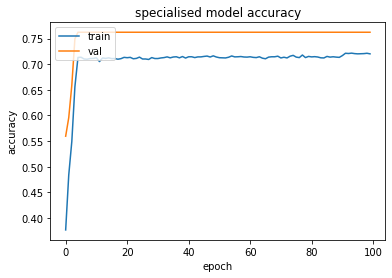

In [37]:
plot_specialised(specialised_history)

In [ ]:
# trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'specialised_model.h5')
# specialised.save(trained_model)

##### Load Saved Model and Evaluate

In [ ]:
# trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'specialised_model.h5')
# specialised_model = load_model(trained_model)

Evaluating Prediction Performance

In [38]:
# Generating Inputs

x_test_ohe,y_test = generate_inputs(vec_test,args,indexes,experiment)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")

results = specialised.evaluate(x_test_ohe, y_test, batch_size=100)
y_pred = specialised.predict(x_test_ohe)
print("test loss, test acc:", results)

Evaluate on test data
70/70 [==============================] - 11s 10ms/step
test loss, test acc: [0.6039534211158752, 0.7001357078552246]


In [39]:
target_names = [index_ne[i] for i in range(len(index_ne))]

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names))

                                              precision    recall  f1-score   support

                                  A_ACCEPTED       0.00      0.00      0.00       576
                        A_CANCELLED_DECLINED       0.00      0.00      0.00        80
W_Filling in information for the application       0.56      1.00      0.72       839
                      W_Fixing incoming lead       1.00      0.99      1.00       716

                                    accuracy                           0.70      2211
                                   macro avg       0.39      0.50      0.43      2211
                                weighted avg       0.54      0.70      0.59      2211



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Confusion Matrix

[[  0   0 576   0]
 [  0   0  80   0]
 [  0   0 839   0]
 [  0   0   7 709]]


<Axes: >

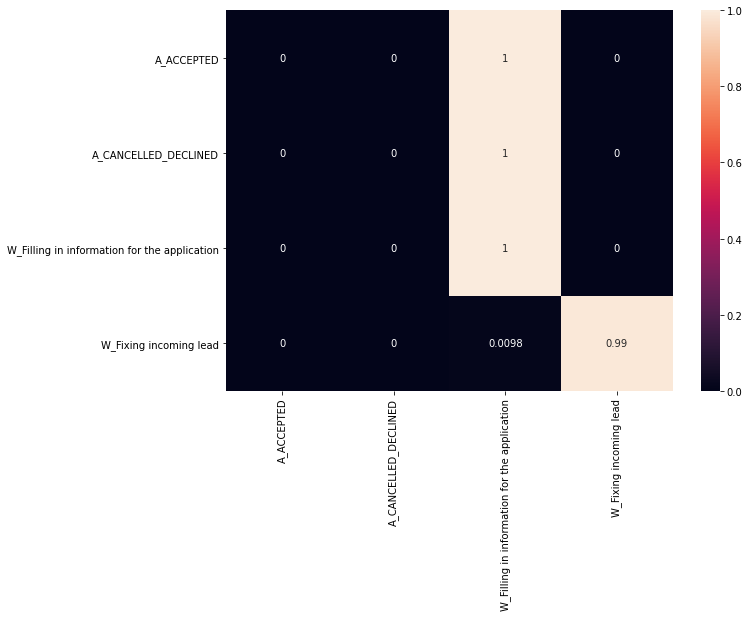

In [40]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)
matrix_sum = np.sum(matrix, axis=1).reshape(-1,1)
matrix_perc = matrix / matrix_sum
df_cm = pd.DataFrame(matrix_perc, index = [index_ne[i] for i in range(len(index_ne))],
                  columns = [index_ne[i] for i in range(len(index_ne))])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

##### Generating Explanations with Attention Layer

In [41]:
model_attn_weights = Model(inputs=specialised.input,
              outputs=[specialised.output, specialised.get_layer('timestep_attention').output,specialised.get_layer('ac_importance').output ,specialised.get_layer('rl_importance').output,specialised.get_layer('t_importance').output])

output_with_attention = model_attn_weights.predict(x_test_ohe)

70/70 [==============================] - 11s 10ms/step


###### Global Explanations

In [112]:
explain_global(output_with_attention,x_test,y_test,index_ac,index_rl,3,prediction=3)

###### Local Explanations

In [43]:
df_results = results_df(y_test,y_pred,index_ne)
df_results[(df_results ['ground_truth'] == 'A_ACCEPTED') & (df_results ['pred_class'] == False) & (df_results ['prediction_prob'] >=0.5) ].head(10)

sample_index                                    prediction ground_truth  \
0              0  W_Filling in information for the application   A_ACCEPTED   
1              1  W_Filling in information for the application   A_ACCEPTED   
9              9  W_Filling in information for the application   A_ACCEPTED   
10            10  W_Filling in information for the application   A_ACCEPTED   
20            20  W_Filling in information for the application   A_ACCEPTED   
25            25  W_Filling in information for the application   A_ACCEPTED   
26            26  W_Filling in information for the application   A_ACCEPTED   
33            33  W_Filling in information for the application   A_ACCEPTED   
34            34  W_Filling in information for the application   A_ACCEPTED   
40            40  W_Filling in information for the application   A_ACCEPTED   

    prediction_prob  pred_class  
0            0.5613       False  
1            0.5613       False  
9            0.5613       False  
10           0.5613       False  
20           0.5613       False  
25           0.5613       False  
26           0.5613       False  
33           0.5613       False  
34           0.5613       False  
40           0.5613       False

In [121]:
explain_local(output_with_attention,x_test,y_test,index_ac,index_rl,index_ne,3,11)

prediction: W_Fixing incoming lead
ground truth: W_Fixing incoming lead
prediction probability:0.9771


process flowchart
st192=>start: start none
op193=>operation: A_SUBMITTED_role_112
op194=>operation: A_PARTLYSUBMITTED_role_112
op195=>operation: W_Fixing incoming lead_role_10912
op196=>operation: A_PREACCEPTED_role_10939

st192->op193
op193->op194
op194->op195
op195->op196



